# **New Approach B Baseline: Multi-Task Classification on Frozen Embeddings**

## **Objective**
This notebook implements a lightweight version of "New Approach B".
Instead of fine-tuning the entire DINOv2 model (which is computationally expensive), we train a **Multi-Task Classifier** on top of **pre-computed embeddings**.

This establishes how much performance we can get just from the DINOv2 features combined with Multi-Task Learning (Species + Leaf Shape + Arrangement).

**Methodology:**
1.  **Input:** Loads `aligned_train_embeddings.npy` (features) and `aligned_train_metadata.pkl` (labels).
2.  **Model:** A simple Neural Network (MLP) that takes a 768-dim vector and predicts 3 outputs.
3.  **Loss:** Weighted sum of Species Loss + Shape Loss + Arrangement Loss.



# **1.0 Environment Setup**
We define project paths and ensure access to the data aligned in the previous step.

## **1.1 Mount Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

print("✅ Google Drive mounted successfully.")

Mounted at /content/drive
✅ Google Drive mounted successfully.


## **1.2 Install Required Libraries**

In [2]:
# Install Hugging Face transformers for DINOv2 and other utilities.
# The '-q' flag makes the installation output less verbose.
# We include 'timm' as it's required to build the custom juliostat DINOv2 model.
!pip install pandas scikit-learn torch torchvision tqdm matplotlib timm kagglehub -q

print("✅ Required libraries are installed.")

✅ Required libraries are installed.


## **1.3 Define Project Constants and Paths**

In [3]:
# This cell centralizes all our configuration for easy access and modification.
import os
import torch

# --- Configuration ---

# 1. Define the base path to project folder in Google Drive.
PROJECT_PATH = '/content/drive/My Drive/Colab Notebooks/COS30082_ML_Project'

# 2. Set the device for training (GPU or CPU).
#    This will automatically use the GPU if Colab has assigned one.
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# 3. Define paths to key data files.
#    The master metadata file created locally.
METADATA_FILE = os.path.join(PROJECT_PATH, 'full_visual_metadata.csv')
# The root directory of the unzipped dataset.
DATA_DIR = os.path.join(PROJECT_PATH, 'AML_dataset')

# 4. Set up the persistent Kaggle cache for the custom DINOv2 model.
cache_dir = os.path.join(PROJECT_PATH, 'kaggle_cache')
os.makedirs(cache_dir, exist_ok=True)
os.environ['KAGGLE_CACHE'] = cache_dir

print(f"Project Path: {PROJECT_PATH}")
print(f"Using device: {DEVICE}")
print(f"Kaggle cache path set to: {cache_dir}")

Project Path: /content/drive/My Drive/Colab Notebooks/COS30082_ML_Project
Using device: cuda
Kaggle cache path set to: /content/drive/My Drive/Colab Notebooks/COS30082_ML_Project/kaggle_cache


# **2.0 Data Loading and Preparation**
For training, we do **not** load images. We load the `.npy` array containing features extracted in the Data Aligner step. This makes training incredibly fast.

We also load the `.pkl` dataframe to get the labels (Species, Shape, Arrangement).

## **2.1 Load Metadata and Pre-computed Embeddings**

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# --- Step 1: Load the UNORDERED metadata file ---
# We still need this file to get a complete list of ALL possible species,
# shapes, and arrangements across the entire dataset (train + test).
print(f"Loading UNORDERED metadata from: {METADATA_FILE}")
try:
    df_unordered = pd.read_csv(METADATA_FILE)
    print("✅ Unordered metadata (for full class map) loaded successfully.")
except FileNotFoundError:
    print(f"❌ ERROR: Metadata file not found at {METADATA_FILE}.")
    raise

Loading UNORDERED metadata from: /content/drive/My Drive/Colab Notebooks/COS30082_ML_Project/full_visual_metadata.csv
✅ Unordered metadata (for full class map) loaded successfully.


In [5]:
# --- Step 2: Load the new, perfectly aligned training data and embeddings ---
ALIGNED_EMBEDDINGS_PATH = os.path.join(PROJECT_PATH, 'aligned_train_embeddings.npy')
ALIGNED_METADATA_PATH = os.path.join(PROJECT_PATH, 'aligned_train_metadata.pkl')

print("\nLoading perfectly aligned training data...")
try:
    # This 'df' is now GUARANTEED to match the embeddings array row-for-row.
    # It contains only the training data (4744 samples).
    df = pd.read_pickle(ALIGNED_METADATA_PATH)
    full_embeddings_array = np.load(ALIGNED_EMBEDDINGS_PATH)
    print("✅ Aligned training data and embeddings loaded successfully.")
    print(f"DataFrame shape: {df.shape}, Embeddings shape: {full_embeddings_array.shape}")
except FileNotFoundError:
    print("❌ ERROR: Aligned data files not found. Please run the 'Data_Aligner.ipynb' script first.")
    raise


Loading perfectly aligned training data...
✅ Aligned training data and embeddings loaded successfully.
DataFrame shape: (4744, 9), Embeddings shape: (4744, 768)


In [6]:
# --- Step 3: Create Training and Validation Sets ---
# This logic is now safe because 'df' and 'full_embeddings_array' are aligned.
indices = np.arange(len(df))

# We split the indices, not the dataframe, to preserve the original index numbers
# which directly correspond to the rows in full_embeddings_array.
train_indices, val_indices = train_test_split(
    indices,
    test_size=0.2,
    random_state=42,
    stratify=df['species_label'].to_numpy()
)

train_df = df.iloc[train_indices]
val_df = df.iloc[val_indices]

print(f"\nData split complete:")
print(f"Training set size:   {len(train_df)} images")
print(f"Validation set size: {len(val_df)} images")


Data split complete:
Training set size:   3795 images
Validation set size: 949 images


# **3.0 Model Definition and Dataset Setup**
We define a Neural Network (MLP) that takes a 768-dimensional feature vector and outputs predictions for:
1.  **Species** (Primary Task)
2.  **Leaf Shape** (Auxiliary Task)
3.  **Leaf Arrangement** (Auxiliary Task)

## **3.1 Define the PyTorch Dataset**

In [7]:
from torch.utils.data import Dataset, DataLoader

# This custom Dataset class is designed to work with our pre-computed embeddings.
# It uses the DataFrame indices to pull the correct embeddings from the large array.
class MultiTaskEmbeddingDataset(Dataset):
    def __init__(self, dataframe, embeddings_array):
        # Store the original indices from the full dataframe (0 to 4743)
        self.original_indices = dataframe.index.to_numpy()
        self.embeddings = embeddings_array

        # Store the labels as PyTorch tensors for efficiency
        self.species_labels = torch.tensor(dataframe['species_label'].values, dtype=torch.long)
        self.shape_labels = torch.tensor(dataframe['leaf_shape_label'].values, dtype=torch.long)
        self.arr_labels = torch.tensor(dataframe['leaf_arrangement_label'].values, dtype=torch.long)

    def __len__(self):
        # The length is the number of samples in this split (e.g., train or val)
        return len(self.original_indices)

    def __getitem__(self, idx):
        # Use the index 'idx' (from 0 to len(self)) to find the original index
        original_index = self.original_indices[idx]

        # Use that original index to get the correct embedding from the numpy array.
        # We use .copy() to ensure the data is copied into a new array, preventing potential
        # issues with negative strides or non-writable buffers when converting to Tensor.
        embedding = torch.from_numpy(self.embeddings[original_index].copy())

        # Return the embedding and its corresponding set of labels
        return (
            embedding,
            self.species_labels[idx],
            self.shape_labels[idx],
            self.arr_labels[idx]
        )

print("✅ MultiTaskEmbeddingDataset class defined.")

✅ MultiTaskEmbeddingDataset class defined.


## **3.2 Define the Multi-Task Model Architecture**

In [8]:
import torch.nn as nn

# This class defines our neural network. It has a shared "body" to learn common
# features and three separate "heads" to make predictions for each task.
class MultiTaskClassifier(nn.Module):
    def __init__(self, input_dim, num_species, num_shapes, num_arrs):
        super().__init__()
        # Shared Body: Learns a high-level representation of the plant
        self.shared_body = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5)  # Dropout helps prevent overfitting
        )
        # Heads: Each head is a specialized linear classifier for one task
        self.species_head = nn.Linear(512, num_species)
        self.shape_head = nn.Linear(512, num_shapes)
        self.arr_head = nn.Linear(512, num_arrs)

    def forward(self, x):
        # Pass the input embedding through the shared body
        shared_features = self.shared_body(x)

        # Pass the shared features to each head to get the final predictions
        species_output = self.species_head(shared_features)
        shape_output = self.shape_head(shared_features)
        arr_output = self.arr_head(shared_features)

        return species_output, shape_output, arr_output

print("✅ MultiTaskClassifier class defined.")

✅ MultiTaskClassifier class defined.


# **4.0 Model Training**
This is the core of our experiment. We will define hyperparameters, set up our data loaders, and write the training loop. The loop will process the data in batches, calculate a combined loss from all three tasks, and update the model's weights to improve its performance.

We train for ~50 epochs. The loss is calculated as:
$$ Loss = Loss_{Species} + 0.3 \times Loss_{Shape} + 0.3 \times Loss_{Arrangement} $$

## **4.1 Set Hyperparameters and Initialize for Training**

In [9]:
from sklearn.metrics import top_k_accuracy_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# --- Hyperparameters ---
LEARNING_RATE = 1e-4
EPOCHS = 50
BATCH_SIZE = 64
ALPHA = 1.0      # Weight for the primary task (species classification)
BETA_SHAPE = 0.3 # Weight for the leaf shape auxiliary task
BETA_ARR = 0.3   # Weight for the leaf arrangement auxiliary task

# --- Setup DataLoaders ---
train_dataset_mt = MultiTaskEmbeddingDataset(train_df, full_embeddings_array)
val_dataset_mt = MultiTaskEmbeddingDataset(val_df, full_embeddings_array)

train_loader_mt = DataLoader(train_dataset_mt, batch_size=BATCH_SIZE, shuffle=True)
val_loader_mt = DataLoader(val_dataset_mt, batch_size=BATCH_SIZE, shuffle=False)

# --- Initialize Model, Optimizer, and Loss Function ---
num_species = df_unordered['species_label'].nunique()
num_shapes = df_unordered['leaf_shape_label'].nunique()
num_arrs = df_unordered['leaf_arrangement_label'].nunique()

# --- Get the number of features directly from the loaded embeddings array ---
num_features = full_embeddings_array.shape[1]

multitask_model = MultiTaskClassifier(
    input_dim=num_features,
    num_species=num_species,
    num_shapes=num_shapes,
    num_arrs=num_arrs
).to(DEVICE)

optimizer = torch.optim.Adam(multitask_model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# --- Lists to store metrics for plotting ---
history = {
    'train_loss': [],
    'val_loss': [],
    'val_top1_acc': [],
    'val_top5_acc': []
}

print("✅ Setup complete. Ready for training.")
print(f"Model will train for {EPOCHS} epochs.")

✅ Setup complete. Ready for training.
Model will train for 50 epochs.


## **4.2 Run the Training and Validation Loop**

In [10]:
# This cell executes the main training process.

print("--- Starting Training ---")

for epoch in tqdm(range(EPOCHS), desc="Training Progress"):
    # --- Training Phase ---
    multitask_model.train()
    total_train_loss = 0

    for embeddings, s_labels, sh_labels, a_labels in train_loader_mt:
        embeddings, s_labels, sh_labels, a_labels = embeddings.to(DEVICE), s_labels.to(DEVICE), sh_labels.to(DEVICE), a_labels.to(DEVICE)
        optimizer.zero_grad()
        s_preds, sh_preds, a_preds = multitask_model(embeddings)
        loss_species = criterion(s_preds, s_labels)
        loss_shape = criterion(sh_preds, sh_labels)
        loss_arr = criterion(a_preds, a_labels)
        total_loss = (ALPHA * loss_species) + (BETA_SHAPE * loss_shape) + (BETA_ARR * loss_arr)
        total_loss.backward()
        optimizer.step()
        total_train_loss += total_loss.item()

    # --- Validation Phase ---
    multitask_model.eval()
    total_val_loss = 0 # ADDED: Initialize validation loss
    val_preds_list = []
    val_labels_list = []

    with torch.no_grad():
        for embeddings, s_labels, sh_labels, a_labels in val_loader_mt: # Load all labels for loss calculation
            embeddings, s_labels, sh_labels, a_labels = embeddings.to(DEVICE), s_labels.to(DEVICE), sh_labels.to(DEVICE), a_labels.to(DEVICE)

            s_preds, sh_preds, a_preds = multitask_model(embeddings)

            # --- THE FIX: Calculate validation loss ---
            loss_species = criterion(s_preds, s_labels)
            loss_shape = criterion(sh_preds, sh_labels)
            loss_arr = criterion(a_preds, a_labels)
            val_loss_batch = (ALPHA * loss_species) + (BETA_SHAPE * loss_shape) + (BETA_ARR * loss_arr)
            total_val_loss += val_loss_batch.item()

            val_preds_list.append(s_preds.cpu())
            val_labels_list.append(s_labels.cpu())

    val_preds_all = torch.cat(val_preds_list)
    val_labels_all = torch.cat(val_labels_list)

    # --- Calculate and store metrics for this epoch ---
    avg_train_loss = total_train_loss / len(train_loader_mt)
    avg_val_loss = total_val_loss / len(val_loader_mt) # ADDED: Average validation loss
    val_top1_acc = top_k_accuracy_score(val_labels_all, val_preds_all, k=1)
    val_top5_acc = top_k_accuracy_score(val_labels_all, val_preds_all, k=5)

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss) # ADDED: Store validation loss
    history['val_top1_acc'].append(val_top1_acc)
    history['val_top5_acc'].append(val_top5_acc)

    print(f"Epoch {epoch+1:02d}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Top-1 Acc: {val_top1_acc*100:.2f}%")

print("\n✅ Training complete.")

--- Starting Training ---


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01/50 | Train Loss: 5.1743 | Val Loss: 4.8062 | Val Top-1 Acc: 26.24%
Epoch 02/50 | Train Loss: 4.5526 | Val Loss: 4.1786 | Val Top-1 Acc: 49.42%
Epoch 03/50 | Train Loss: 3.9130 | Val Loss: 3.5155 | Val Top-1 Acc: 62.80%
Epoch 04/50 | Train Loss: 3.2919 | Val Loss: 2.9424 | Val Top-1 Acc: 69.34%
Epoch 05/50 | Train Loss: 2.7950 | Val Loss: 2.4975 | Val Top-1 Acc: 74.29%
Epoch 06/50 | Train Loss: 2.3927 | Val Loss: 2.1618 | Val Top-1 Acc: 75.76%
Epoch 07/50 | Train Loss: 2.1099 | Val Loss: 1.9022 | Val Top-1 Acc: 79.03%
Epoch 08/50 | Train Loss: 1.8873 | Val Loss: 1.7030 | Val Top-1 Acc: 81.14%
Epoch 09/50 | Train Loss: 1.6599 | Val Loss: 1.5403 | Val Top-1 Acc: 82.51%
Epoch 10/50 | Train Loss: 1.5158 | Val Loss: 1.4117 | Val Top-1 Acc: 84.62%
Epoch 11/50 | Train Loss: 1.3981 | Val Loss: 1.3068 | Val Top-1 Acc: 84.40%
Epoch 12/50 | Train Loss: 1.2844 | Val Loss: 1.2195 | Val Top-1 Acc: 84.83%
Epoch 13/50 | Train Loss: 1.1995 | Val Loss: 1.1427 | Val Top-1 Acc: 85.88%
Epoch 14/50 

## **4.3 Plot Training and Validation Graphs**

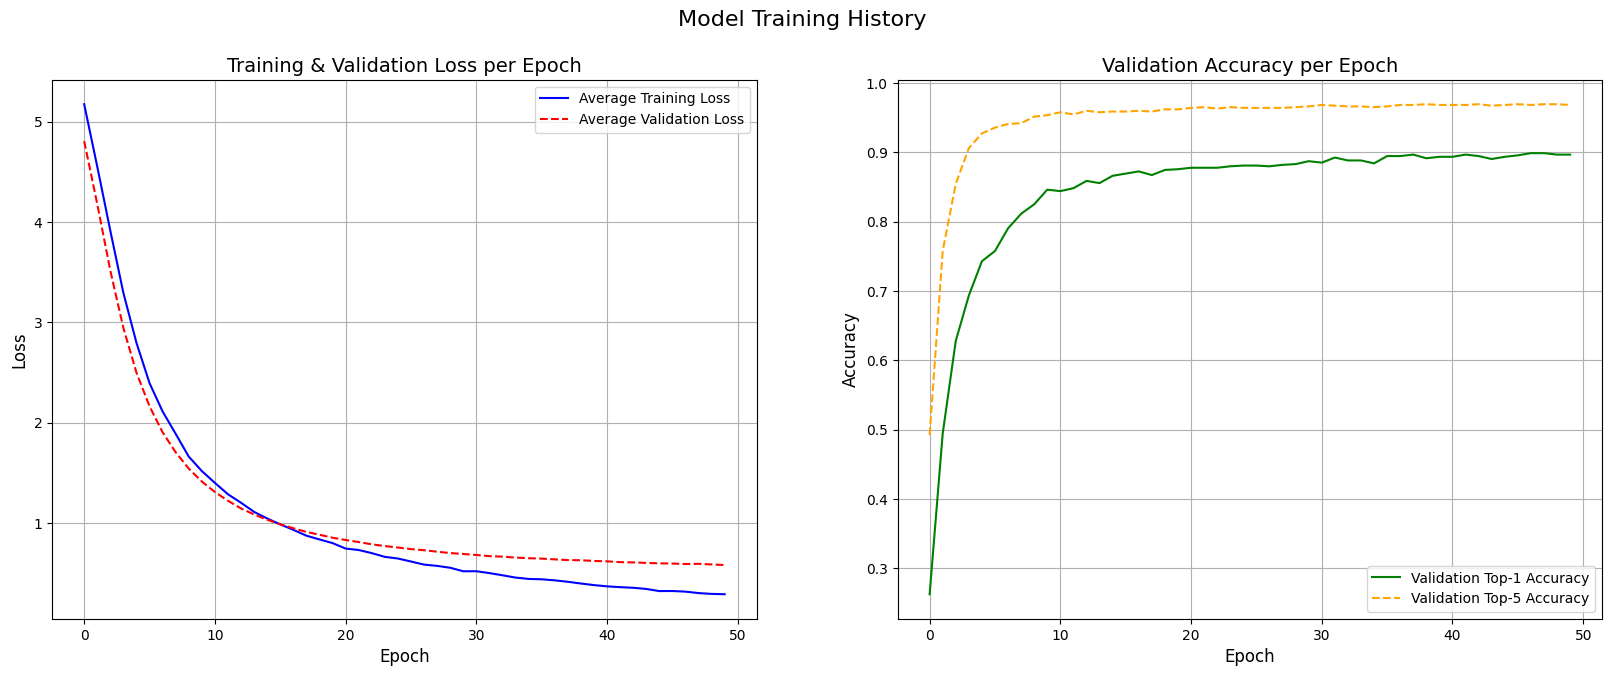

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# Plot Training vs. Validation Loss
ax1.plot(history['train_loss'], label='Average Training Loss', color='blue')
ax1.plot(history['val_loss'], label='Average Validation Loss', color='red', linestyle='--')
ax1.set_title('Training & Validation Loss per Epoch', fontsize=14)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()
ax1.grid(True)

# Plot Validation Accuracy
ax2.plot(history['val_top1_acc'], label='Validation Top-1 Accuracy', color='green')
ax2.plot(history['val_top5_acc'], label='Validation Top-5 Accuracy', color='orange', linestyle='--')
ax2.set_title('Validation Accuracy per Epoch', fontsize=14)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend()
ax2.grid(True)

plt.suptitle('Model Training History', fontsize=16)
plt.show()

# **5.0 Final Evaluation**
To measure the pure effectiveness of the **Multi-Task Learning** approach, we perform a standard evaluation.

**Methodology:**
1.  **Input:** Raw Test Images.
2.  **Preprocessing:** Standard `Resize` to 518x518 and `CenterCrop`.
3.  **Feature Extraction:** Pass image through the frozen DINOv2 backbone.
4.  **Prediction:** Pass the feature through our trained Multi-Task Classifier.

## **5.1 Load and Prepare ALL Test Data**

In [12]:
import timm
import kagglehub
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# --- 1. Load Frozen DINOv2 Backbone ---
print("--- Loading Frozen DINOv2 Backbone ---")
path_to_model_files = kagglehub.model_download("juliostat/dinov2_patch14_reg4_onlyclassifier_then_all/pyTorch/default")
weights_filename = next((f for f in os.listdir(path_to_model_files) if f.endswith(('.pth', '.pt', '.tar'))), None)
weights_path = os.path.join(path_to_model_files, weights_filename)

# Create model (No Head)
dino_backbone = timm.create_model('vit_base_patch14_reg4_dinov2.lvd142m', pretrained=False)
dino_backbone.reset_classifier(0, '')

# Load weights
checkpoint = torch.load(weights_path, map_location='cpu', weights_only=False)
state_dict = checkpoint.get('state_dict', checkpoint)
dino_backbone.load_state_dict(state_dict, strict=False)
dino_backbone.to(DEVICE)
dino_backbone.eval()
print("✅ Backbone Loaded.")

# --- 2. Define Standard Transform (No TTA) ---
# We use the exact same transform used during Validation
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

test_transform = transforms.Compose([
    transforms.Resize(518, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(518),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

# --- 3. Define Test Dataset ---
class TestImageDataset(Dataset):
    def __init__(self, filepaths, labels, data_dir, transform):
        self.filepaths = filepaths
        self.labels = labels
        self.data_dir = data_dir
        self.transform = transform
    def __len__(self): return len(self.filepaths)
    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.filepaths[idx])
        image = Image.open(img_path).convert("RGB")
        return self.transform(image), self.labels[idx]

# --- 4. Prepare Data Lists ---
test_list_path = os.path.join(DATA_DIR, 'list', 'test.txt')
groundtruth_path = os.path.join(DATA_DIR, 'list', 'groundtruth.txt')

# Load Labels
y_test_classids = pd.read_csv(groundtruth_path, sep=' ', header=None)[1].to_numpy()
classid_to_label = dict(zip(df_unordered['classid'], df_unordered['species_label']))
y_test_numpy = np.array([classid_to_label[cid] for cid in y_test_classids])

# Load Filepaths
test_filepaths = pd.read_csv(test_list_path, sep=' ', header=None, names=['filepath', 'classid'])['filepath'].tolist()

# Create Loader
test_dataset = TestImageDataset(test_filepaths, y_test_numpy, DATA_DIR, test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"✅ Test Data Ready: {len(test_dataset)} images.")

--- Loading Frozen DINOv2 Backbone ---
✅ Backbone Loaded.
✅ Test Data Ready: 207 images.


## **5.2 Evaluate Model and Report Performance**

In [17]:
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, top_k_accuracy_score

# 1. Setup
multitask_model.eval()
dino_backbone.eval()

all_probs = []
all_labels = []

print("--- Running Standard Inference (Single Crop) ---")

# 2. Inference Loop
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images = images.to(DEVICE)

        # Extract Features
        # Output Shape is usually [Batch, 1374, 768] (Sequence of tokens)
        full_features = dino_backbone(images)

        # --- THE CRITICAL FIX ---
        # We only want the [CLS] token (Index 0) which represents the whole image
        if full_features.ndim == 3:
            features = full_features[:, 0, :]
        else:
            features = full_features

        # Predict
        s_preds, _, _ = multitask_model(features)

        # Probabilities
        probs = F.softmax(s_preds, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.numpy())

# 3. Process Outputs
final_probs = np.vstack(all_probs)
final_labels = np.concatenate(all_labels).flatten()
final_preds = np.argmax(final_probs, axis=1)

print("\n--- DEBUG SHAPES (FIXED) ---")
print(f"Probs Shape:  {final_probs.shape} (Should be [207, 100])")
print(f"Labels Shape: {final_labels.shape} (Should be [207])")
print(f"Preds Shape:  {final_preds.shape}   (Should be [207])")

# 4. Load Breakdown Metadata
groundtruth_path = os.path.join(DATA_DIR, 'list', 'groundtruth.txt')
no_pairs_path = os.path.join(DATA_DIR, 'list', 'class_without_pairs.txt')

# Load IDs
gt_ids = pd.read_csv(groundtruth_path, sep=' ', header=None)[1].to_numpy()
with open(no_pairs_path, 'r') as f:
    herbarium_only_classids = {int(line.strip()) for line in f}

# Create Masks
is_herbarium_only_mask = np.isin(gt_ids, list(herbarium_only_classids))
is_with_pairs_mask = ~is_herbarium_only_mask

# 5. Calculate & Print Metrics
all_possible_labels = np.arange(final_probs.shape[1])

print("\n" + "="*40)
print("FINAL RESULTS (Multi-Task Baseline)")
print("="*40)

# Overall
acc1 = accuracy_score(final_labels, final_preds)
acc5 = top_k_accuracy_score(final_labels, final_probs, k=5, labels=all_possible_labels)
print(f"\n[Overall Test Set]")
print(f"   Top-1 Accuracy: {acc1*100:.2f}%")
print(f"   Top-5 Accuracy: {acc5*100:.2f}%")

# With Pairs
if sum(is_with_pairs_mask) > 0:
    acc1_p = accuracy_score(final_labels[is_with_pairs_mask], final_preds[is_with_pairs_mask])
    acc5_p = top_k_accuracy_score(final_labels[is_with_pairs_mask], final_probs[is_with_pairs_mask], k=5, labels=all_possible_labels)
    print(f"\n[Category: With Pairs] (Species seen in field)")
    print(f"   Top-1 Accuracy: {acc1_p*100:.2f}%")
    print(f"   Top-5 Accuracy: {acc5_p*100:.2f}%")
else:
    print("\n[Category: With Pairs] No samples found.")

# Herbarium Only
if sum(is_herbarium_only_mask) > 0:
    acc1_h = accuracy_score(final_labels[is_herbarium_only_mask], final_preds[is_herbarium_only_mask])
    acc5_h = top_k_accuracy_score(final_labels[is_herbarium_only_mask], final_probs[is_herbarium_only_mask], k=5, labels=all_possible_labels)
    print(f"\n[Category: Herbarium Only] (Species NEVER seen in field)")
    print(f"   Top-1 Accuracy: {acc1_h*100:.2f}%")
    print(f"   Top-5 Accuracy: {acc5_h*100:.2f}%")
else:
    print("\n[Category: Herbarium Only] No samples found.")

print("="*40)

--- Running Standard Inference (Single Crop) ---


Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]


--- DEBUG SHAPES (FIXED) ---
Probs Shape:  (207, 100) (Should be [207, 100])
Labels Shape: (207,) (Should be [207])
Preds Shape:  (207,)   (Should be [207])

FINAL RESULTS (Multi-Task Baseline)

[Overall Test Set]
   Top-1 Accuracy: 75.85%
   Top-5 Accuracy: 83.57%

[Category: With Pairs] (Species seen in field)
   Top-1 Accuracy: 96.08%
   Top-5 Accuracy: 98.69%

[Category: Herbarium Only] (Species NEVER seen in field)
   Top-1 Accuracy: 18.52%
   Top-5 Accuracy: 40.74%


# **6.0 Save the Trained Model**
The final step is to save the trained model's weights. This allows us to load the model back later for further analysis, for the final testing on the test set, or for use in the user interface, without needing to retrain it.

In [18]:
# The final step is to save the trained model's weights.
MODEL_SAVE_PATH = os.path.join(PROJECT_PATH, 'pipeline2_multitask_model.pth')
torch.save(multitask_model.state_dict(), MODEL_SAVE_PATH)
print(f"\n✅ Model weights saved successfully to: {MODEL_SAVE_PATH}")


✅ Model weights saved successfully to: /content/drive/My Drive/Colab Notebooks/COS30082_ML_Project/pipeline2_multitask_model.pth


# **7.0: Visualizing Predictions on the Test Set**
 In this section, we'll qualitatively analyze the model's performance by picking random images from the test set and visualizing what the model predicts.

## **7.1: Prepare Data and Mappings for Visualization**

In [19]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

print("--- Step 1: Preparing data for visualization ---")

# a) Load the filepaths for the test set
test_list_path = os.path.join(DATA_DIR, 'list/test.txt')
test_paths_df = pd.read_csv(test_list_path, sep=' ', header=None, names=['filepath', 'classid'])
test_image_paths = test_paths_df['filepath'].tolist()

# b) Create mapping dictionaries to translate between different label types
print("Creating label-to-name and label-to-classid mappings...")
label_to_name = dict(zip(df_unordered['species_label'], df_unordered['species_name']))
label_to_classid = dict(zip(df_unordered['species_label'], df_unordered['classid']))
classid_to_name = dict(zip(df_unordered['classid'], df_unordered['species_name']))

# c) Identify which test set indices belong to each category
# These masks were created in Section 5.2 and should be in memory.
# is_with_pairs_mask
# is_herbarium_only_mask
indices_with_pairs = np.where(is_with_pairs_mask)[0]
indices_herbarium_only = np.where(is_herbarium_only_mask)[0]

print(f"Found {len(indices_with_pairs)} 'With-Pairs' samples and {len(indices_herbarium_only)} 'Herbarium-Only' samples in the test set.")
print("✅ Preparation complete.")

--- Step 1: Preparing data for visualization ---
Creating label-to-name and label-to-classid mappings...
Found 153 'With-Pairs' samples and 54 'Herbarium-Only' samples in the test set.
✅ Preparation complete.


## **7.2: Define Helper and Visualization Functions**

In [20]:
def find_example_training_image(class_id, train_df, data_dir):
    """
    Finds a random example image from the training set for a given class ID.
    Prefers herbarium images as they are often clearer references.
    """
    candidate_rows = train_df[train_df['classid'] == class_id]
    if candidate_rows.empty:
        return None
    candidate_paths = candidate_rows['filepath'].tolist()
    herbarium_paths = [p for p in candidate_paths if 'herbarium' in p]
    if herbarium_paths:
        return os.path.join(data_dir, random.choice(herbarium_paths))
    else:
        return os.path.join(data_dir, random.choice(candidate_paths))

def visualize_single_prediction(test_image_path, true_classid, top5_pred_labels, top5_probs, train_df, data_dir):
    """
    Creates a plot showing the test image, the model's top guess, and the top 5 predictions.
    """
    true_name = f"'{classid_to_name.get(true_classid, 'Unknown')}' (ID: {true_classid})"
    top1_pred_label = top5_pred_labels[0]
    top1_pred_classid = label_to_classid.get(top1_pred_label, -1) # Use .get for safety
    is_correct = (top1_pred_classid == true_classid)
    top5_names = [f"'{label_to_name.get(p_label)}' (ID: {label_to_classid.get(p_label)})" for p_label in top5_pred_labels]

    test_image = Image.open(test_image_path)
    predicted_example_path = find_example_training_image(top1_pred_classid, train_df, data_dir)
    predicted_example_image = Image.open(predicted_example_path) if predicted_example_path else Image.new('RGB', (518, 518), 'lightgray')

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    axs[0].imshow(test_image); axs[0].set_title("Test Image", fontsize=14); axs[0].axis('off')
    axs[1].imshow(predicted_example_image); axs[1].set_title(f"Model's Top Guess:\n{top5_names[0]}", fontsize=14); axs[1].axis('off')
    fig.suptitle(f"Prediction for Image: {os.path.basename(test_image_path)}\n"
                 f"Actual Species: {true_name}\n"
                 f"Result: {'✅ CORRECT' if is_correct else '❌ INCORRECT'}",
                 fontsize=16, color='green' if is_correct else 'red')
    text_lines = ["Top 5 Predictions:", "="*20] + [f"{i+1}: {name}\n    (Confidence: {prob:.2%})" for i, (name, prob) in enumerate(zip(top5_names, top5_probs))]
    plt.figtext(0.92, 0.5, "\n".join(text_lines), fontsize=12, va="center", ha="left")
    plt.tight_layout(rect=[0, 0, 0.85, 0.9])
    plt.show()

## **7.3: Run and Visualize Predictions**


--- Step 2: Generating and Visualizing Predictions ---

   Analyzing 2 random 'With-Pairs' samples

Processing 'With-Pairs' image 62: 256749.jpg


/tmp/ipython-input-588004504.py:39: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 0.85, 0.9])
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


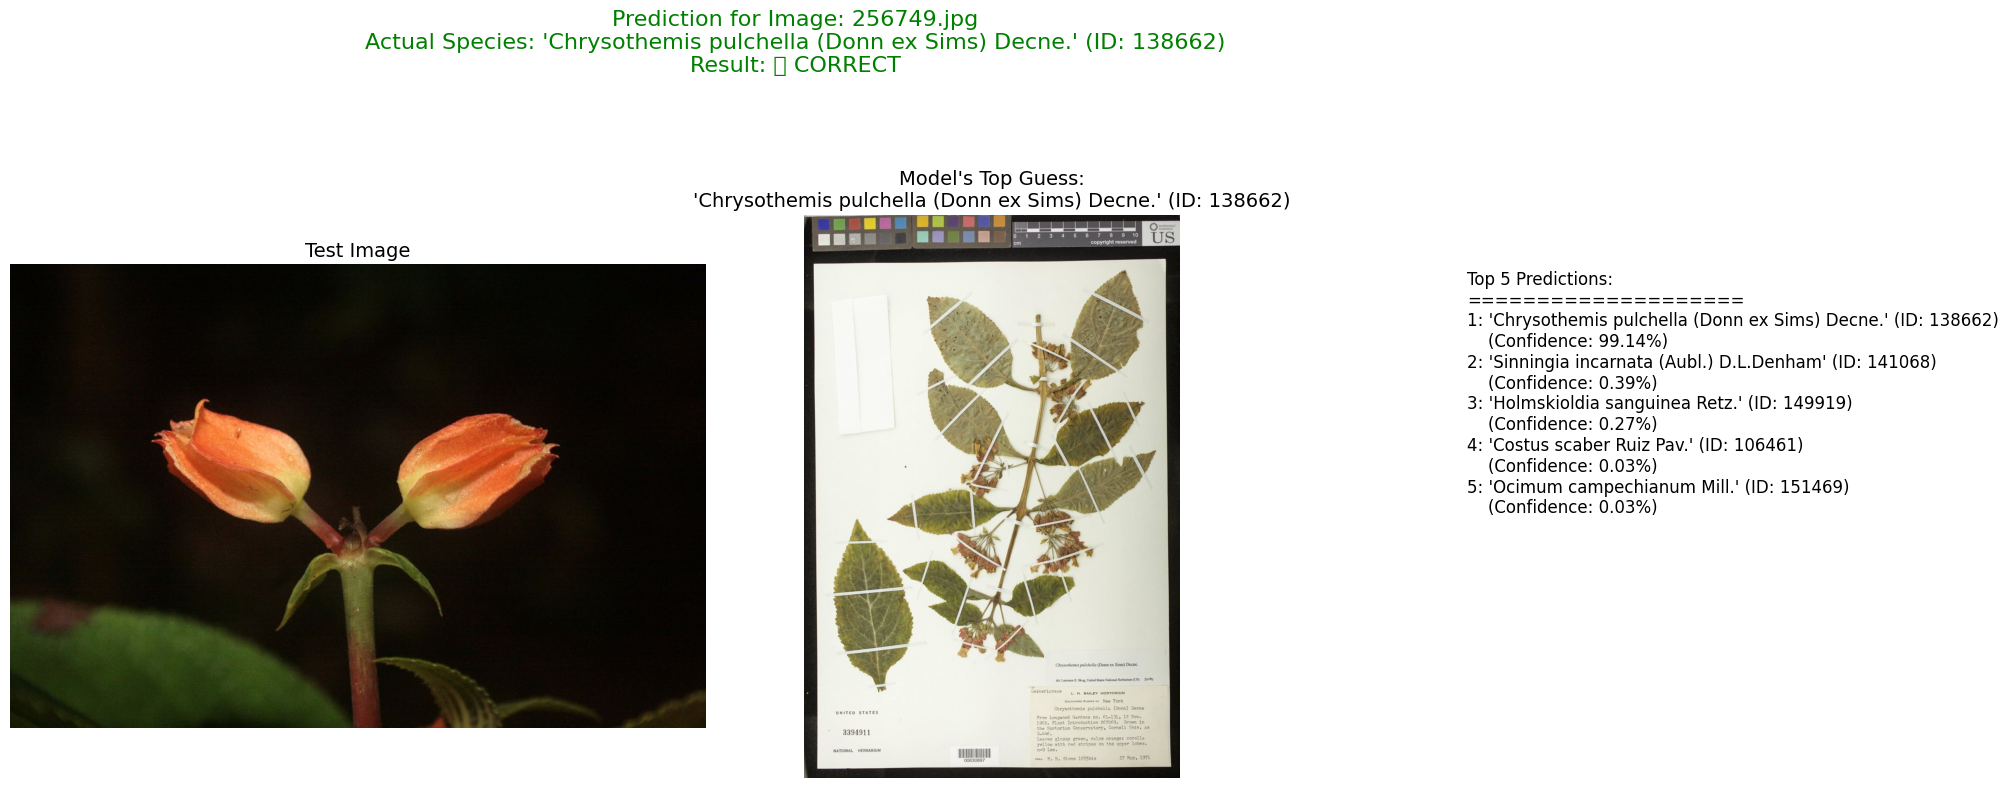


Processing 'With-Pairs' image 72: 256172.jpg


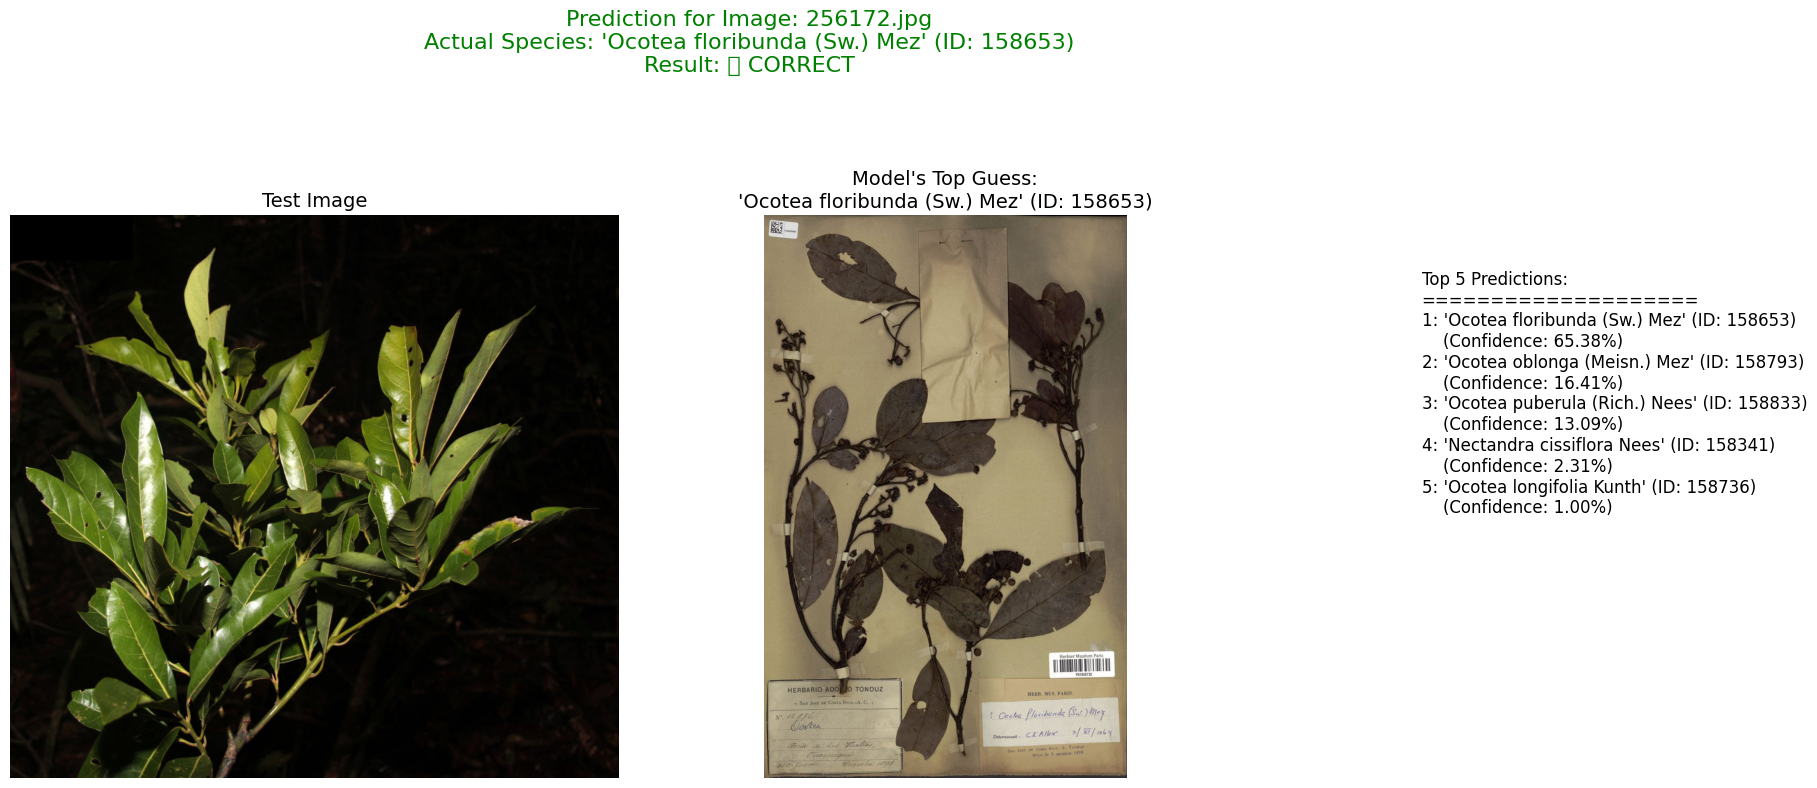


   Analyzing 2 random 'Herbarium-Only' samples

Processing 'Herbarium-Only' image 16: 197081.jpg


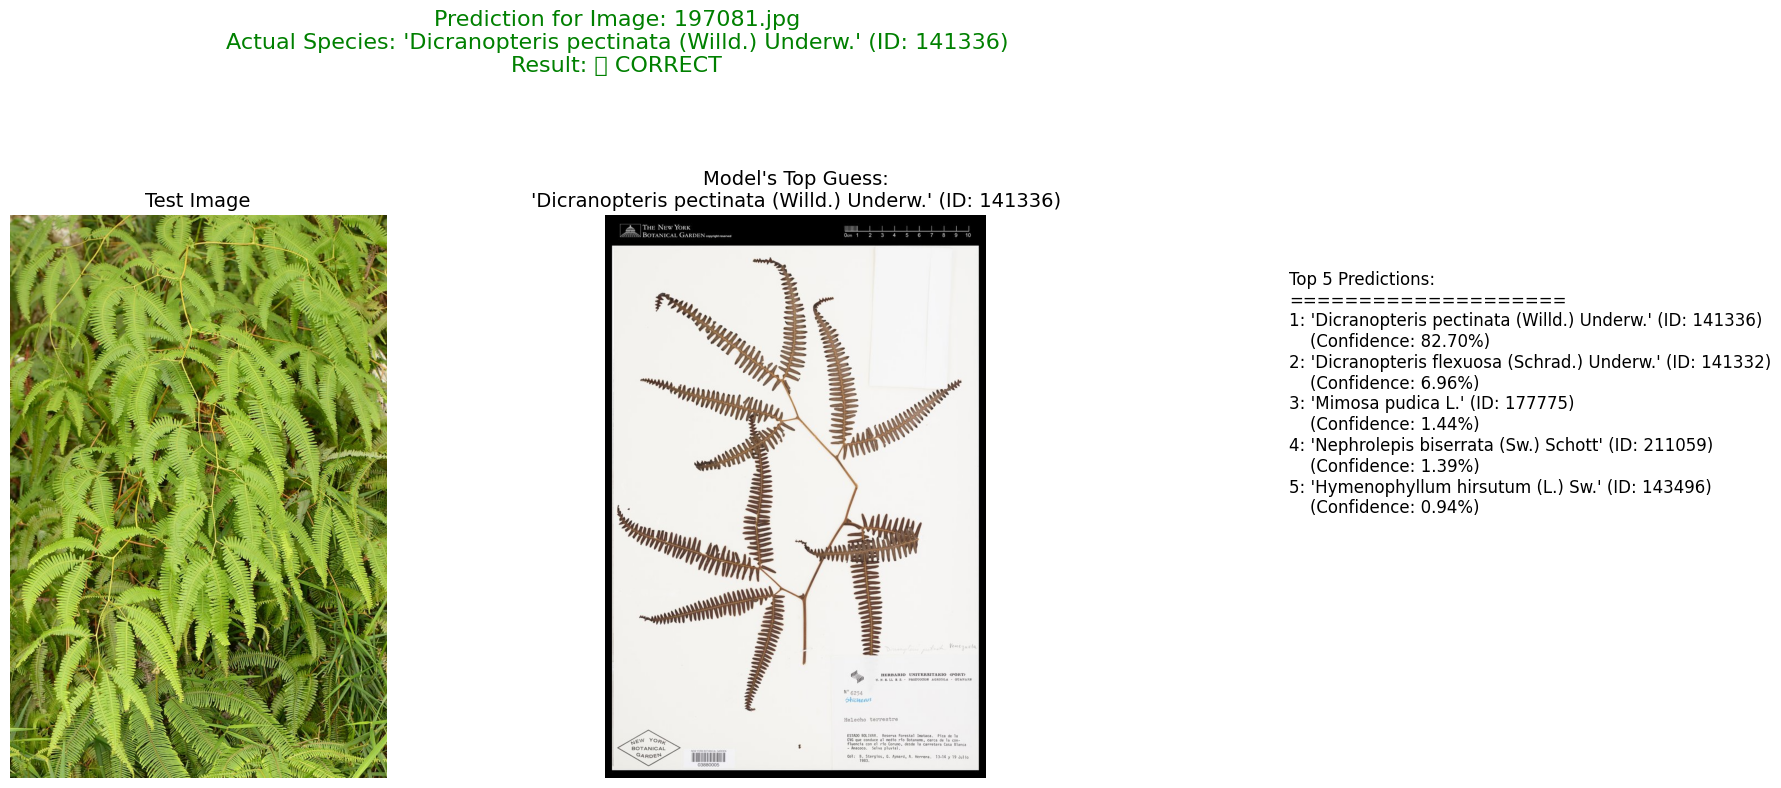


Processing 'Herbarium-Only' image 19: 1134.jpg


/tmp/ipython-input-588004504.py:39: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 0.85, 0.9])
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


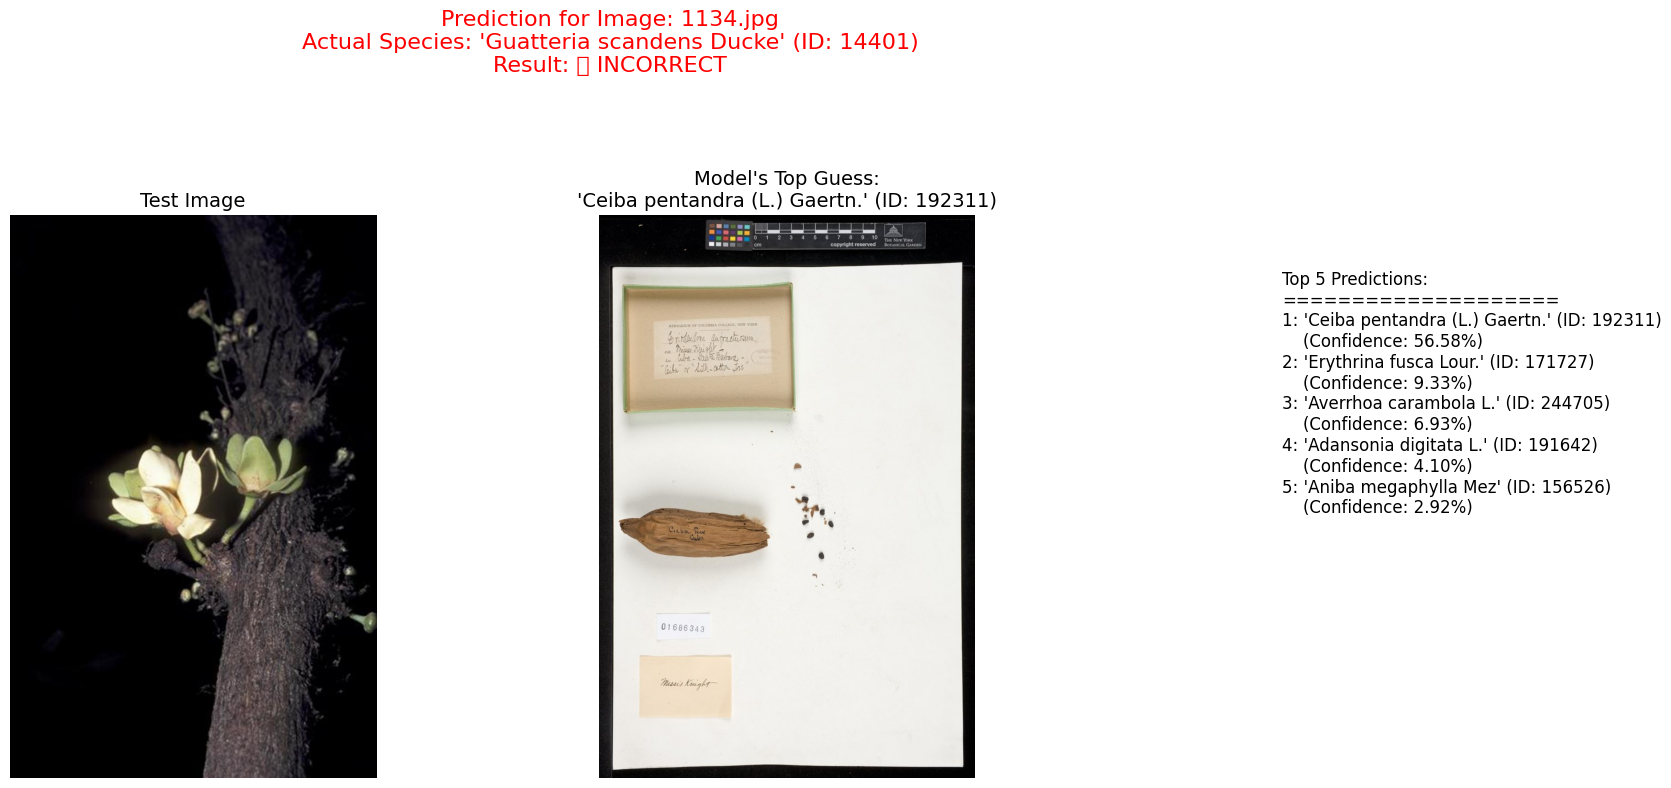

In [23]:
import matplotlib.pyplot as plt
import random
import numpy as np
from PIL import Image
import torch

print("\n--- Step 2: Generating and Visualizing Predictions ---")
multitask_model.eval()
dino_backbone.eval()

def run_live_visualization(indices, category_name):
    if len(indices) == 0:
        print(f"No '{category_name}' samples to visualize.")
        return

    print("\n" + "="*50)
    print(f"   Analyzing 2 random '{category_name}' samples")
    print("="*50)

    samples_to_show = random.sample(list(indices), min(2, len(indices)))

    for idx in samples_to_show:
        # 1. Load Image
        image_path = test_image_paths[idx]
        full_path = os.path.join(DATA_DIR, image_path)

        try:
            raw_image = Image.open(full_path).convert("RGB")
        except Exception as e:
            print(f"Could not load image {image_path}: {e}")
            continue

        print(f"\nProcessing '{category_name}' image {idx}: {os.path.basename(image_path)}")

        # 2. Preprocess & Extract Feature (Live)
        # FIX: Use 'test_transform' which was defined in Section 5.0
        input_tensor = test_transform(raw_image).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            # Extract feature from backbone
            features = dino_backbone(input_tensor)

            # Handle feature shape (take [CLS] token if 3D)
            if features.ndim == 3:
                features = features[:, 0, :]

            # Predict using Classifier
            s_preds, _, _ = multitask_model(features)
            probabilities = torch.softmax(s_preds, dim=1).cpu().numpy().flatten()

        # 3. Get Top 5
        top5_pred_indices = np.argsort(probabilities)[-5:][::-1]
        top5_probabilities = probabilities[top5_pred_indices]

        # 4. Visualize
        true_class_id = y_test_classids[idx]
        visualize_single_prediction(
            full_path,
            true_class_id,
            top5_pred_indices,
            top5_probabilities,
            df, # Train DataFrame (for finding prototypes)
            DATA_DIR
        )

# Run for both categories
run_live_visualization(indices_with_pairs, "With-Pairs")
run_live_visualization(indices_herbarium_only, "Herbarium-Only")